In [1]:
import glob
import json
import copy
import hist
import pickle
import numpy as np
import mplhep as hep
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
from coffea import processor
from hist.intervals import poisson_interval, ratio_uncertainty

np.seterr(divide="ignore", invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
lumis = {
    "2017": 41477,
    "2018": 59830,
}
xsecs = {
    "TTTo2L2Nu": 88.29,
    "TTToHadronic": 377.96,
    "TTToSemiLeptonic": 365.34,
    "ST_s-channel_4f_leptonDecays": 3.549,
    "ST_t-channel_antitop_5f_InclusiveDecays": 71.74,
    "ST_t-channel_top_5f_InclusiveDecays": 119.7,
    "ST_tW_antitop_5f_inclusiveDecays": 34.97,
    "ST_tW_top_5f_inclusiveDecays": 34.91,
    "WJetsToLNu_HT-100To200": 1395,
    "WJetsToLNu_HT-200To400": 407.9,
    "WJetsToLNu_HT-400To600": 57.48,
    "WJetsToLNu_HT-600To800": 12.87,
    "WJetsToLNu_HT-800To1200": 5.366,
    "WJetsToLNu_HT-1200To2500": 1.074,
    "WJetsToLNu_HT-2500ToInf": 0.008001,
    "DYJetsToLL_M-50_HT-70to100": 140.0,
    "DYJetsToLL_M-50_HT-100to200": 160.7,
    "DYJetsToLL_M-50_HT-200to400": 48.63,
    "DYJetsToLL_M-50_HT-400to600": 6.993,
    "DYJetsToLL_M-50_HT-600to800": 1.761,
    "DYJetsToLL_M-50_HT-800to1200": 0.8021,
    "DYJetsToLL_M-50_HT-1200to2500": 0.1937,
    "DYJetsToLL_M-50_HT-2500toInf": 0.003514,
    "WW": 75.95,
    "WZ": 27.59,
    "ZZ": 12.17 ,
    "VBFHToWWTo2L2Nu": 3.879,
    "VBFHToWWToLNuQQ": 3.892,
    "GluGluHToWWToLNuQQ": 28.88,
    "DYJetsToLL_M-50": 6424.0,
    "DYJetsToLL_M-10to50": 20490.0,
}

In [3]:
def open_output(fname):
    try:
        with open(fname, "rb") as f:
            h = pickle.load(f)
    except:
            print(fname)
    return h

def open_metadata(fname):
    with open(fname, "r") as f:
        metadata = json.load(f)
    return metadata

def group_outputs(output_directory: str, metadata=False) -> dict:
    """group output .pkl files by sample"""
    if metadata:
        extension = ".json"
        output_files = glob.glob(f"{output_directory}/metadata/*{extension}", recursive=True)
    else:
        extension = ".pkl"
        output_files = glob.glob(f"{output_directory}/*{extension}", recursive=True)
        
    grouped_outputs = {}
    for output_file in output_files:
        # get output file names
        sample_name = output_file.replace("_metadata", "").split("/")[-1].split(extension)[0]
        if sample_name.rsplit("_")[-1].isdigit():
            sample_name = "_".join(sample_name.rsplit("_")[:-1])
        # append file names to grouped_outputs
        if sample_name in grouped_outputs:
            grouped_outputs[sample_name].append(output_file)
        else:
            grouped_outputs[sample_name] = [output_file]
    return grouped_outputs

def group_histograms(scaled_histograms: dict) -> dict:
    """group scaled histograms by process"""
    hists = {
        "DYJetsToLL": [],
        "WJetsToLNu": [],
        "VV": [],
        "tt": [],
        "SingleTop": [],
        "Data": [],
        "Higgs": [],
    }
    for sample in scaled_histograms:
        if "DYJetsToLL" in sample:
            hists["DYJetsToLL"].append(scaled_histograms[sample])
        elif "WJetsToLNu" in sample:
            hists["WJetsToLNu"].append(scaled_histograms[sample])
        elif (sample == "WW") or (sample == "WZ") or (sample == "ZZ"):
            hists["VV"].append(scaled_histograms[sample])
        elif "TTT" in sample:
            hists["tt"].append(scaled_histograms[sample])
        elif "ST" in sample:
            hists["SingleTop"].append(scaled_histograms[sample])
        elif sample in ["SingleMuon", "SingleElectron", "SingleTau"]:
            hists["Data"] = scaled_histograms[sample]
        elif ("VBFH" in sample) or ("GluGluH" in sample):
            hists["Higgs"].append(scaled_histograms[sample])
    
    for sample in hists:
        if sample == "Data": continue
        hists[sample] = processor.accumulate(hists[sample])
    return hists


def postprocess(output_directory="./", year="2017"):
    # compute lumi-xsec weights
    grouped_outputs_metadata = group_outputs(output_directory=output_directory, metadata=True)
    grouped_metadata = {}
    first_accumulated_metadata = {}
    for sample in grouped_outputs_metadata:
        grouped_metadata[sample] = []
        for fname in grouped_outputs_metadata[sample]:
            output = open_metadata(fname)
            meta = {}
            meta["sumw"] = output["sumw"]
            meta["weighted_final_nevents"] = output["weighted_final_nevents"]
            grouped_metadata[sample].append(meta)
        first_accumulated_metadata[sample] = processor.accumulate(grouped_metadata[sample]) 
    
    weights = {}
    for sample in first_accumulated_metadata:
        if sample not in ["SingleElectron", "SingleMuon", "SingleTau"]:
            weights[sample] = lumis[year] * xsecs[sample] / first_accumulated_metadata[sample]["sumw"]
            
    weights["SingleElectron"] = 1
    weights["SingleMuon"] = 1
    weights["SingleTau"] = 1
    
    # group histograms by sample
    grouped_outputs = group_outputs(output_directory=output_directory)
    grouped_histograms = {}
    first_accumulated_histograms = {}
    for sample in grouped_outputs:
        grouped_histograms[sample] = []
        for fname in grouped_outputs[sample]:
            output = open_output(fname)
            if output:
                output_sample = list(output.keys())[0]
                output = output[output_sample]["histograms"]
                grouped_histograms[sample].append(output)
        first_accumulated_histograms[sample] = processor.accumulate(grouped_histograms[sample])
    
    # scale histograms to lumi-xsec
    scaled_histos = {}
    for sample in first_accumulated_histograms:
        scaled_histos[sample] = {}
        for feature in first_accumulated_histograms[sample]:
            scaled_histos[sample][feature] = first_accumulated_histograms[sample][feature] * weights[sample]
    
    # group histograms by process
    processed_histograms = group_histograms(scaled_histos)

    return processed_histograms

def get_label_map(lepton_flavor: str):
    common_labels = {
        "jet_pt": r"$p_T$(b-Jet$_{0}$) [GeV]",
        "jet_eta": r"$\eta$(b-Jet$_{0}$)",
        "jet_phi": r"$\phi$(b-Jet$_{0}$)",
        "met": r"$p_T^{miss}$ [GeV]",
        "met_phi": r"$\phi(p_T^{miss})$",
        "npvs": r"$N_{pvs}$",
        "njets": r"$N_{jets}$",
    }
    lepton_ids = {"ele": "e", "mu": "\mu", "tau": "\tau"}
    lepton_labels = {
        "lepton_pt": rf"$p_T({lepton_ids[lepton_flavor]})$ [GeV]",
        "lepton_relIso": f"${lepton_ids[lepton_flavor]}$ RelIso",
        "lepton_eta": rf"$\eta({lepton_ids[lepton_flavor]})$",
        "lepton_phi": rf"$\phi({lepton_ids[lepton_flavor]})$",
        "lepton_bjet_mass": rf"$m({lepton_ids[lepton_flavor]}, $b-Jet$_{0})$ [GeV]",
        "lepton_bjet_dr": rf"$\Delta R$(${lepton_ids[lepton_flavor]}$, b-Jet$_{0}$)",
        "lepton_met_mass": rf"$m_T$(${lepton_ids[lepton_flavor]}$, $p_T^{{miss}}$) [GeV]",
        "lepton_met_delta_phi": rf"$\Delta \phi({lepton_ids[lepton_flavor]}, p_T^{{miss}})$",
        "lepton_met_bjet_mass": rf"$m_T^{{tot}}({lepton_ids[lepton_flavor]}, $b-Jet$_{0}, p_T^{{miss}})$ [GeV]",
        "dilepton_mass": rf"$m_{{{lepton_ids[lepton_flavor]}{lepton_ids[lepton_flavor]}}}$ [GeV]",
    }
    return {**common_labels, **lepton_labels}


def get_projected_nominal_hists(processed_hists, kin, feature, variation="nominal") -> tuple:
    sample_map = {
        "VV": "Diboson",
        "SingleTop": "Single Top",
        "WJetsToLNu": r"W$(\ell \nu)$+jets",
        "tt": r"$t\bar{t}$",
        "DYJetsToLL": r"DY$(\ell\ell)$+jets",
        "Higgs": "Higgs",
        "SingleMuon": "Data",
        "SingleElectron": "Data",
        "SingleTau": "Data",
    }
    color_map = {
        "VV": "red",
        "SingleTop": "olive",
        "WJetsToLNu": "blue",
        "tt": "purple",
        "DYJetsToLL": "orange",
        "Higgs": "green",
    }
    mcs_colors = []
    mcs_nominal = []
    mcs_labels = []
    mcs_variations = {}
    for sample in processed_hists:
        if processed_hists[sample] is None:
            continue
        if sample != "Data":
            mcs_labels.append(sample_map[sample])
            mcs_colors.append(color_map[sample])
            mcs_nominal.append(
                processed_hists[sample][kin][{"variation": variation}].project(feature)
            )

    return mcs_nominal, mcs_labels, mcs_colors


def get_projected_syst_hists(processed_hists, kin, feature) -> dict:
    mcs_syst = {}
    for sample in processed_hists:
        if processed_hists[sample] is None:
            continue
        if sample != "Data":
            for variation in processed_histograms[sample][kin].axes["variation"]:
                if variation == "nominal":
                    continue
                variation_hist = processed_histograms[sample][kin][
                    {"variation": variation}
                ].project(feature)
                if variation in mcs_syst:
                    mcs_syst[variation].append(variation_hist)
                else:
                    mcs_syst[variation] = [variation_hist]

    syst_variations = {}
    for variation in mcs_syst:
        syst_variations[variation] = processor.accumulate(mcs_syst[variation])

    return syst_variations


def get_uncert_band(total_mc: hist.Hist, syst_variations: dict):
    # nominal values
    nominal_values = total_mc.values()
    # get nominal stat up/down uncertainty
    nom_stat_down, nom_stat_up = poisson_interval(
        values=total_mc.values(), variances=total_mc.variances()
    )
    # initialize up/down errors
    bin_error_down = np.abs(nom_stat_down - nominal_values) ** 2
    bin_error_up = np.abs(nom_stat_up - nominal_values) ** 2
    
    # add systematics
    for syst in syst_variations:
        syst_values = syst_variations[syst].values()

        # add up variation
        max_syst_values = np.max(
            np.stack([nominal_values, syst_values]), axis=0
        )       
        max_syst_values = np.abs(max_syst_values - nominal_values)
        bin_error_up += max_syst_values ** 2
        
        # add down variation
        min_syst_values = np.min(
            np.stack([nominal_values, syst_values]), axis=0
        )
        min_syst_values = np.abs(min_syst_values - nominal_values)
        bin_error_down += min_syst_values ** 2

    band_up = nominal_values + np.sqrt(bin_error_up)
    band_down = nominal_values - np.sqrt(bin_error_down)
    
    return band_down, band_up


def plot_ratio(
    total_data,
    total_mc,
    total_mc_down,
    total_mc_up,
    rax,
    yratio_limits: tuple = None,
    lepton_flavor: str = "mu",
):
    numerator = total_data.values()
    denominator = total_mc.values()
    ratio = numerator / denominator
    edges = total_mc.axes.edges[0]
    centers = total_mc.axes.centers[0]

    # plot ratio x error bar
    xerr = edges[1:] - edges[:-1]
    rax.errorbar(
        x=centers,
        y=ratio,
        xerr=xerr / 2,
        fmt=f"ko",
        markersize=5,
    )

    # plot ratio y error bar
    error_down, error_up = ratio_uncertainty(
        num=numerator, denom=denominator, uncertainty_type="poisson-ratio"
    )
    ratio_error_up = ratio + error_up
    ratio_error_down = ratio - error_down
    rax.vlines(centers, ratio_error_down, ratio_error_up, color="k")

    # plot ratio uncertaity interval
    yup = np.concatenate([[0], total_mc_up / denominator])
    ydown = np.concatenate([[0], total_mc_down / denominator])

    ratio_uncertainty_band = rax.fill_between(
        edges,
        yup,
        ydown,
        step="pre",
        color="lightgray",
        hatch="////",
        alpha=0.6,
        edgecolor="k",
        linewidth=0,
    )
    # get ratio plot y-limits
    if yratio_limits is None:
        up_limit = np.nanmax(ratio_error_up)
        down_limit = np.nanmin(ratio_error_down)
        scale = 1.1
        yup = scale * up_limit
        ydown = down_limit - scale * (1 - down_limit)

        up_distance = up_limit - 1
        down_distance = down_limit - 1
        if abs(up_distance) > 2 * abs(down_distance):
            ydown = 1 - up_distance
        if yup < 0:
            yup = 1 + scale * max(down_distance, up_distance)

        up_distance = abs(1 - yup)
        down_distance = abs(1 - ydown)
        max_distance = max(down_distance, up_distance)
        ydown, yup = 1 - max_distance, 1 + max_distance
    else:
        ydown, yup = yratio_limits

    label_map = get_label_map(lepton_flavor)
    rax.set(
        xlabel=label_map[feature],
        ylabel="Data / Pred",
        ylim=(ydown, yup),
        facecolor="white",
    )

    # plot horizontal line at unity
    xmin, xmax = rax.get_xlim()
    rax.hlines(1, xmin, xmax, color="k", linestyle=":")

    # plot additional lines
    ymajorticks = rax.get_yticks()
    ymajorticks_mp = (ymajorticks[1:] + ymajorticks[:-1]) / 2
    yticks = np.concatenate([ymajorticks, ymajorticks_mp])
    for ytick in yticks:
        rax.hlines(ytick, xmin, xmax, color="k", linestyle=":", alpha=0.3)


def plot_hist(
    processed_hists: dict,
    kin: str,
    feature: str,
    channel: str,
    lepton_flavor: str = "mu",
    year: str = "2017",
    yratio_limits: tuple = None,
    cms_loc: int = 0,
    figsize: tuple = (8, 8),
    savefig: bool = False,
    format: str = "png",
    variation: str = "nominal",
):
    # global plot configuration
    hep.style.use(hep.style.CMS)
    plt.rcParams.update(
        {
            "font.size": 20,
            "axes.titlesize": 20,
            "axes.labelsize": 20,
            "xtick.labelsize": 12,
            "ytick.labelsize": 12,
            "lines.markersize": 30,
            "legend.fontsize": 14,
            "xtick.minor.width": 1,
            "xtick.minor.size": 4,
            "xtick.major.width": 1,
            "xtick.major.size": 6,
            "ytick.minor.width": 1,
            "ytick.minor.size": 4,
            "ytick.major.width": 1,
            "ytick.major.size": 6,
        }
    )
    # mc and data histograms keyword arguments
    mc_hist_kwargs = {
        "histtype": "fill",
        "stack": True,
        "sort": "yield",
        "linewidth": 0.7,
        "edgecolor": "k",
    }
    data_hist_kwargs = {
        "histtype": "errorbar",
        "color": "k",
        "linestyle": "none",
        "marker": ".",
        "markersize": 10.0,
        "elinewidth": 1,
        "yerr": True,
        "xerr": True,
        "linestyle": "none",
        "marker": ".",
    }

    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=figsize,
        tight_layout=True,
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True,
    )
    # get projected nominal hists and its variations
    mcs_nominal, mcs_labels, mcs_colors = get_projected_nominal_hists(
        processed_hists, kin, feature, variation
    )
    syst_variations = get_projected_syst_hists(processed_hists, kin, feature)
    total_mc = processor.accumulate(mcs_nominal)

    # get data histogram
    total_data = processed_hists["Data"][kin].project(feature)

    # plot data and stacked nominal mc hists
    hep.histplot(total_data, ax=ax, label="Data", flow="none", **data_hist_kwargs)
    hep.histplot(
        mcs_nominal,
        ax=ax,
        label=mcs_labels,
        color=mcs_colors,
        flow="none",
        **mc_hist_kwargs,
    )

    # plot histograms uncert interval
    band_down, band_up = get_uncert_band(total_mc, syst_variations)
    ax.bar(
        x=total_mc.axes.centers[0],
        height=band_up - band_down,
        width=total_mc.axes.widths[0],
        bottom=band_down,
        color="lightgray",
        alpha=0.6,
        label="Stat + Syst unc.",
        hatch="/" * 3,
        edgecolor="black",
        linewidth=0,
    )

    # plot ratio error bars and uncert interval
    plot_ratio(
        total_data,
        total_mc,
        band_down,
        band_up,
        rax,
        yratio_limits=yratio_limits,
        lepton_flavor=lepton_flavor,
    )

    # set axes labels and legend
    if ("eta" in feature) or ("phi" in feature) or ("njets" in feature):
        # change legend configuration
        ncols = 3
        ylim = ax.get_ylim()[1]
        ax.set_ylim(0, ylim + 0.4 * ylim)
        ax.legend(loc="upper center", ncol=3)
    else:
        ax.legend(loc="upper right", ncol=1, fontsize=12)
        
    lep_tag = "e" if lepton_flavor == "ele" else "\mu"
    if channel == "1b1e1mu":
        title = "$1b1e1\mu$"
    elif channel == "2b1l":
        title = f"$2b1{lep_tag}$"
    elif channel == "1b1l":
        title = f"$1b1{lep_tag}$"
    ax.set_title(rf"{title}", fontsize=14)
    ax.set(
        xlabel=None,
        ylabel="Events",
    )
    # set xlimits 
    edges = total_mc.axes.edges[0]
    hist_edges = np.array([[i, j] for i, j in zip(edges[:-1], edges[1:])])
    values_mask = total_mc.values() > 0
    xlimits = np.min(hist_edges[values_mask]), np.max(hist_edges[values_mask]) 
    ax.set(xlim=xlimits)
    rax.set(xlim=xlimits)
    
    # set lumi and CMS text
    lumi_test = {
        "2017": "41.5 fb$^{-1}$ (2017, 13 TeV)",
        "2018": "59.8 fb$^{-1}$ (2018, 13 TeV)",
    }
    hep.cms.lumitext(lumi_test[year], fontsize=15, ax=ax)
    hep.cms.text("Preliminary", loc=cms_loc, ax=ax, fontsize=15)
    if savefig:
        fig.savefig(f"{year}_{lepton_flavor}_{channel}_{feature}.{format}")

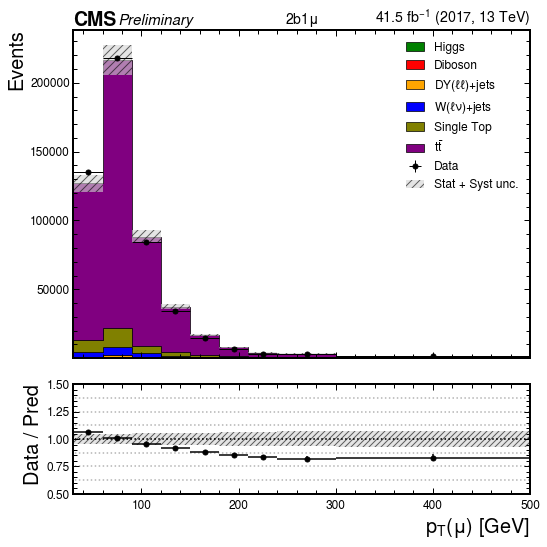

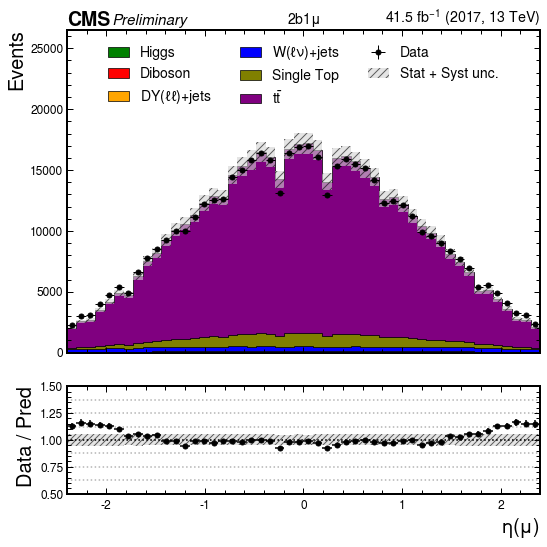

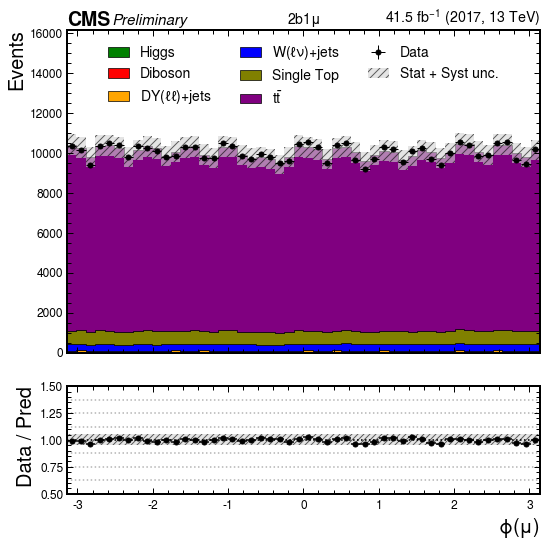

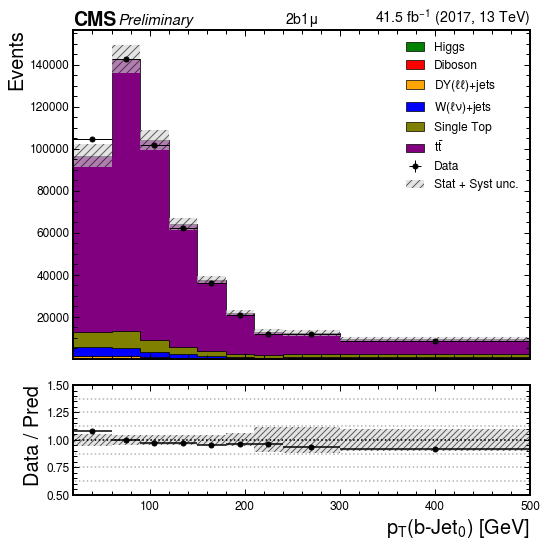

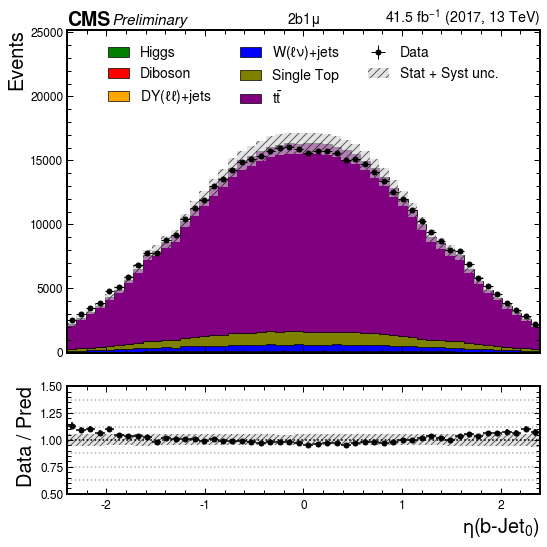

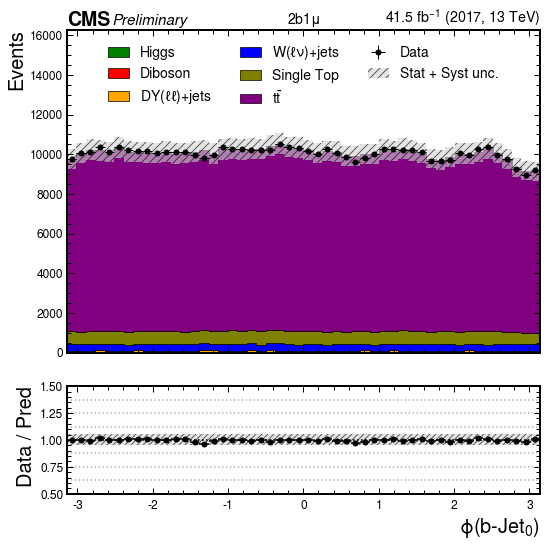

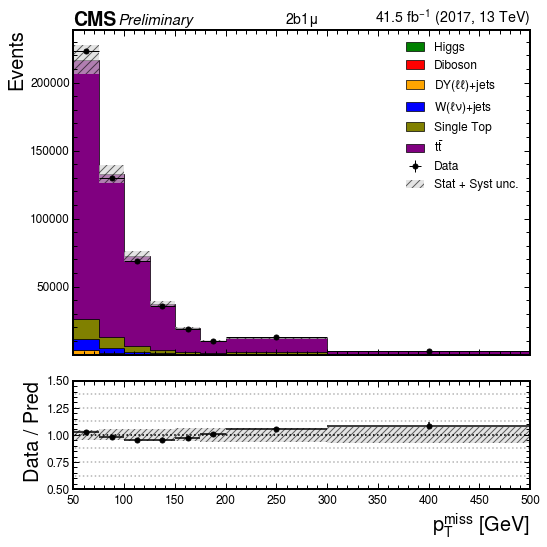

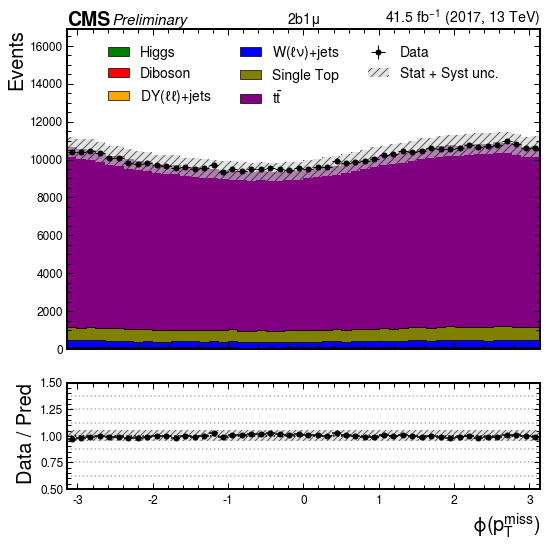

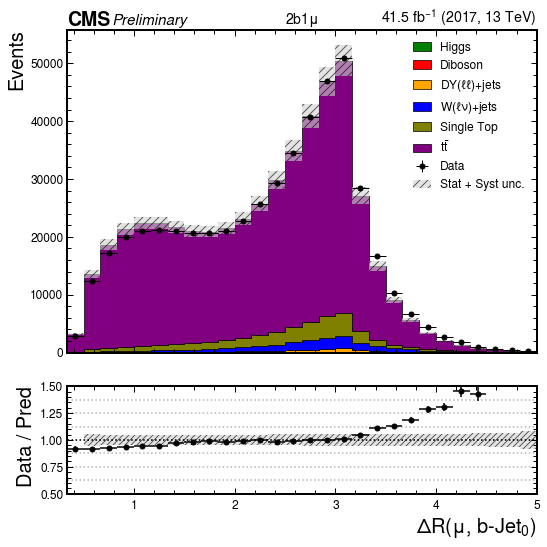

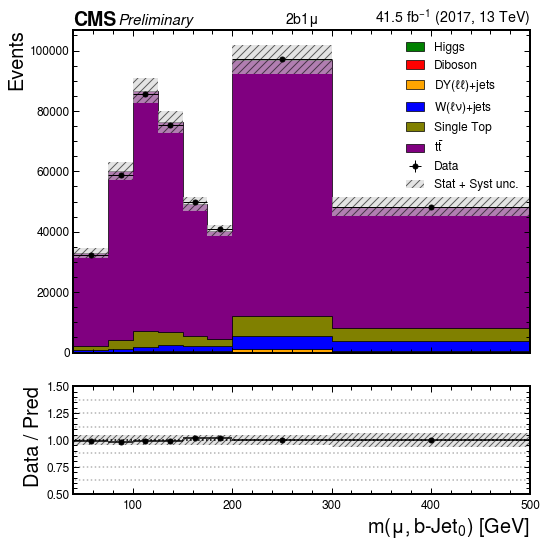

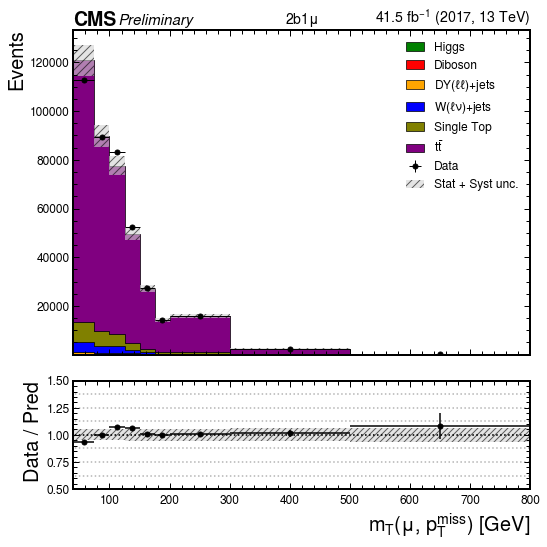

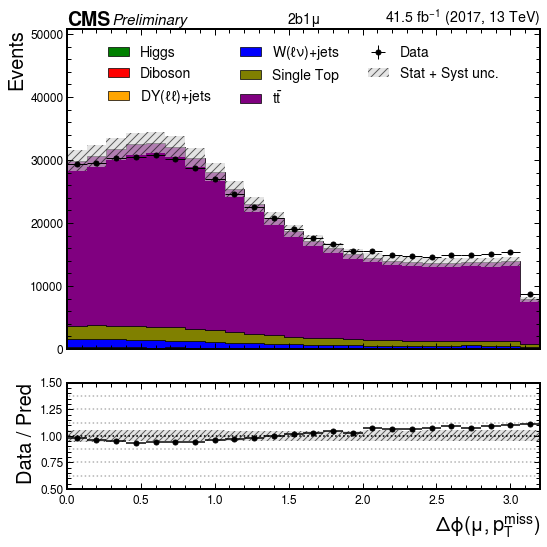

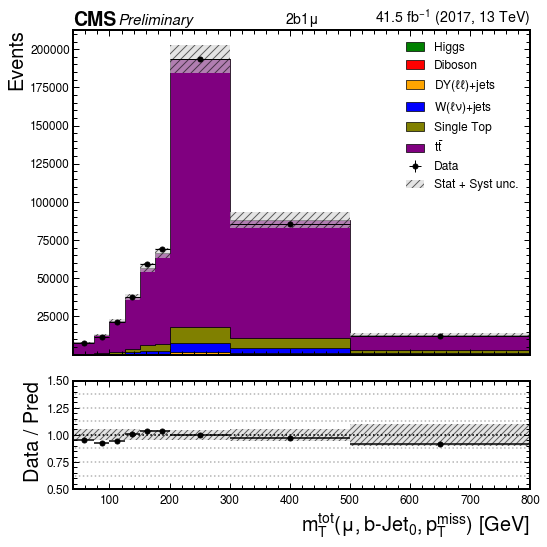

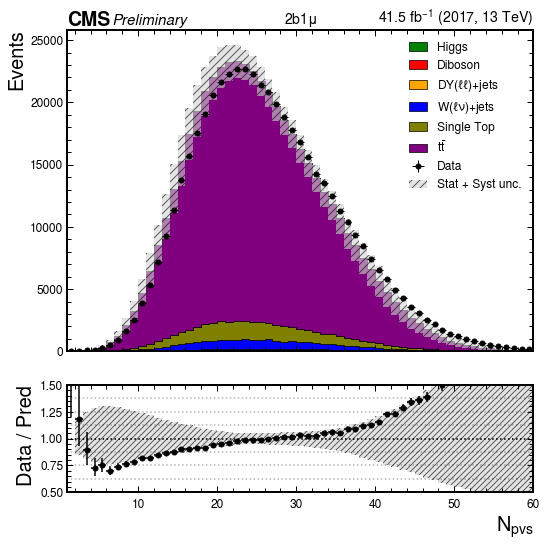

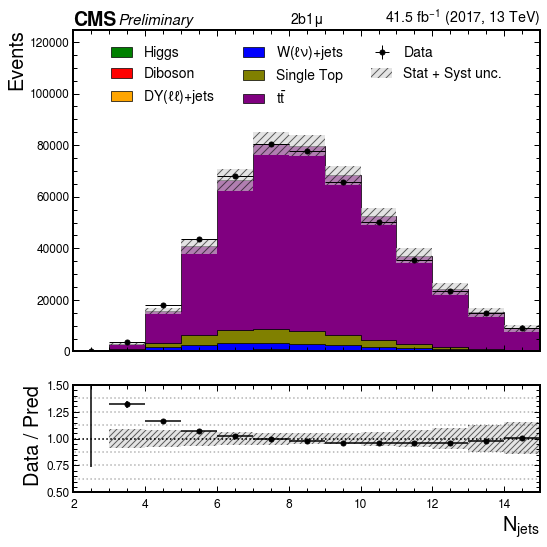

In [4]:
# plot histograms
year = "2017"
channel = "2b1l"
lepton_flavor = "mu"
features = {
    'lepton_kin': ['lepton_pt', 'lepton_eta', 'lepton_phi'],
    'jet_kin': ['jet_pt', 'jet_eta', 'jet_phi'],
    'met_kin': ['met', 'met_phi'],
    'lepton_bjet_kin': ['lepton_bjet_dr', 'lepton_bjet_mass'],
    'lepton_met_kin': ['lepton_met_mass', 'lepton_met_delta_phi'],
    'lepton_met_bjet_kin': ['lepton_met_bjet_mass'],
    "n_kin": ["npvs", "njets"]
}
processed_histograms = postprocess(output_directory="./", year=year)

for kin in features:
    for feature in features[kin]:
        plot_hist(
            processed_histograms, 
            kin=kin, 
            feature=feature, 
            channel=channel, 
            lepton_flavor=lepton_flavor,
            year=year,
            yratio_limits=(0.5, 1.5),
            savefig=True,
            format="png",
        )

In [5]:
def get_report(output_directory, year):
    grouped_outputs_metadata = group_outputs(output_directory, metadata=True)

    # get the raw number of events before and after selection from metadata
    grouped_metadata = {}
    first_accumulated_metadata = {}
    for sample in grouped_outputs_metadata:
        grouped_metadata[sample] = []
        for fname in grouped_outputs_metadata[sample]:
            output = open_metadata(fname)
            meta = {}
            meta["sumw"] = float(output["sumw"])
            meta['weighted_final_nevents'] = float(output['weighted_final_nevents'])
            meta["raw_initial_nevents"] = float(output["raw_initial_nevents"])
            meta["raw_final_nevents"] = float(output["raw_final_nevents"])
            grouped_metadata[sample].append(meta)
        first_accumulated_metadata[sample] = processor.accumulate(grouped_metadata[sample]) 
 
    # create report
    mcs = ["DYJetsToLL", "WJetsToLNu", "VV", "VVV", "tt", "SingleTop", "Higgs"]
    events = {sample: 0 for sample in mcs}
    events.update({"Data": 0})
    errors = events.copy()

    for sample in first_accumulated_metadata:
        if ("SingleElectron" in sample) or ("SingleMuon" in sample) or ("SingleTau" in sample):
            events["Data"] += first_accumulated_metadata[sample]["weighted_final_nevents"]
            errors["Data"] += np.sqrt(events["Data"])
            continue

        # get number of events (including scale factors)
        initial_events = first_accumulated_metadata[sample]['sumw']
        final_events = first_accumulated_metadata[sample]['weighted_final_nevents']
        
        final_events *= lumis[year] * xsecs[sample] / initial_events
        
        # raw events to compute error
        raw_initial_events = first_accumulated_metadata[sample]['raw_initial_nevents']
        raw_final_events = first_accumulated_metadata[sample]['raw_final_nevents']
        
        error = np.sqrt(raw_final_events)
        error *= lumis[year] * xsecs[sample] / raw_initial_events

        if "DYJetsToLL" in sample:
            events["DYJetsToLL"] += final_events
            errors["DYJetsToLL"] += error
        elif "WJetsToLNu" in sample:
            events["WJetsToLNu"] += final_events
            errors["WJetsToLNu"] += error
        elif (sample == "WW") or (sample == "WZ") or (sample == "ZZ"):
            events["VV"] += final_events
            errors["VV"] += error
        elif "TTT" in sample:
            events["tt"] += final_events
            errors["tt"] += error
        elif "ST" in sample:
            events["SingleTop"] += final_events
            errors["SingleTop"] += error
        elif ("VBFH" in sample) or ("GluGluH" in sample):
            events["Higgs"] += final_events
            errors["Higgs"] += error

    # add number of expected events and errors to report
    report_df = pd.DataFrame(columns=["events", "error", "percentage"])
    for sample in events:
        report_df.loc[sample, "events"] = events[sample]
        report_df.loc[sample, "error"] = errors[sample]

    # add percentages to report
    mcs_output = report_df.loc[mcs].copy()
    report_df.loc[mcs, "percentage"] = (
        mcs_output["events"] / mcs_output["events"].sum()
    ) * 100

    # (https://depts.washington.edu/imreslab/2011%20Lectures/ErrorProp-CountingStat_LRM_04Oct2011.pdf)
    # add total background number of expected events and error to report
    report_df.loc["Total bkg", "events"] = np.sum(report_df.loc[mcs, "events"])
    report_df.loc["Total bkg", "error"] = np.sqrt(
        np.sum(report_df.loc[mcs, "error"] ** 2)
    )

    # add data to bacground ratio and error
    data = report_df.loc["Data", "events"]
    data_err = report_df.loc["Data", "error"]
    bkg = report_df.loc["Total bkg", "events"]
    bkg_err = report_df.loc["Total bkg", "error"]

    report_df.loc["Data/bkg", "events"] = data / bkg
    report_df.loc["Data/bkg", "error"] = np.sqrt(
        (1 / bkg) * 2 * data_err*2 + (data / bkg**2) * 2 * bkg_err*2
    )
    # sort processes by percentage
    report_df = report_df.loc[mcs + ["Total bkg", "Data", "Data/bkg"]]
    report_df = report_df.sort_values(by="percentage", ascending=False)

    # drop process with no events
    report_df = report_df.loc[report_df.sum(axis=1) > 0]

    return report_df

get_report(output_directory="./", year=year)

,events,error,percentage
tt,449460.421308,194.101525,89.315297
SingleTop,32515.930184,135.640096,6.461459
WJetsToLNu,16406.237113,182.736366,3.260193
DYJetsToLL,4103.147458,60.623854,0.815364
VV,649.42469,17.592998,0.129052
Higgs,93.777862,19.834866,0.018635
Total bkg,503228.938615,306.340341,NaN
Data,501908.0,708.454656,NaN
Data/bkg,0.997375,0.089777,NaN
